# 11. Job Scheduling Problem

The **Job Scheduling Problem** is a well-known optimization problem where a set of tasks needs to be assigned to a set of workers. The goal is to minimize the **makespan**—the time required for the worker with the maximum workload.

Each task has a specific processing time, and the objective is to assign tasks to workers such that the total workload is as balanced as possible. The number of tasks assigned to each worker may vary, but the aim is to ensure that no worker is overloaded relative to others.

### Optimization Function

The objective function to be minimized is the **makespan**, which can be formulated as:

$$
E = \max_{i} \left( \sum_{j \in T_i} t(j) \right)
$$

Where:
* $T_i$ represents the set of tasks assigned to **worker $i$**.
* $t(j)$ is the processing time of **task $j$**.

### Simulated Annealing Algorithm

The algorithm follows these steps to find an optimal or near-optimal solution:

1.  **Initialization:** Start with a **random task assignment** among workers.
2.  **Move Generation:** Two types of possible moves should be performed alternatively:
    * **Task Swap (Exchange Process):** Swap the assignments of two tasks between workers.
    * **Task Migration (Move Process):** Move a task from one worker to another. This allows workers to have different numbers of tasks.
3.  **Evaluation:** After the task move or swap, calculate the new makespan $E'$.
4.  **Acceptance Criteria:**
    * **If the new makespan is better** ($E' < E$): Accept the new configuration immediately.
    * **If the new makespan is worse** ($E' > E$): Accept the new solution with a probability given by the **Metropolis criterion**:

    $$
    P = e^{-(E' - E) / T}
    $$

    Where $T$ is the current temperature.
5.  **Cooling:** Gradually decrease the temperature $T$ over time. As the temperature lowers, the probability of accepting worse solutions decreases, allowing the algorithm to focus on fine-tuning the job scheduling.

In [43]:
import numpy as np
import random

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])
n_workers = 2

#Function that assignes randomly a task to a worker
def create_initial_assigment(task_dur, n_workers):
    n_task = len(task_dur)
    initial_assigment = []
    for i in task_dur:
        initial_assigment.append(random.randint(0,n_workers-1))
    initial_assigment = np.array(initial_assigment)

    return initial_assigment

print(create_initial_assigment(task_dur, n_workers))

#Function that calculates makespan
def calculate_makespan(task_dur, assigment):
    #bincount can easely sum the durations of the tasks of each worker
    charges = np.bincount(assigment, weights=task_dur)
    makespan = np.max(charges)

    return makespan

print(calculate_makespan(task_dur, np.array([0,1,0,1])))

#Function which makes task swap.
def task_swap(assigment):
    new_assigment = assigment.copy()
    n_task = len(new_assigment)

    swap_1 = 0
    swap_2 = 0

    #Ensure that we swap two different tasks
    while (swap_1 == swap_2):
        swap_1 = random.randint(0,n_task-1)
        swap_2 = random.randint(0,n_task-1)

    new_assigment[swap_1], new_assigment[swap_2] = new_assigment[swap_2], new_assigment[swap_1]

    return new_assigment

print(task_swap(np.array([0,1,0,1])))

def task_migration(assigment, n_workers):
    
    new_assigment = assigment.copy()
    n_task = len(new_assigment)

    new_worker = random.randint(0,n_workers-1)
    ran_index = random.randint(0,n_task-1)
    old_worker = new_assigment[ran_index]
    while (new_worker == old_worker):
        new_worker = random.randint(0,n_workers-1)
    
    new_assigment[ran_index] = new_worker
    return new_assigment

print(task_migration(np.array([0,1,0,1]), 2))


[1 1 0 0]
11.0
[1 0 0 1]
[1 1 0 1]


In [44]:
#Defining one algorithm step
def MC_step(task_dur, assigment, n_workers, T, acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps, makespan_list):

    #Step 1: Calculate initial makespan
    makespan = calculate_makespan(task_dur, assigment)

    #Step 2: Make the swap
    assigment_swap = task_swap(assigment)

    #Step 3: calculate new makespan
    new_makespan = calculate_makespan(task_dur, assigment_swap)

    #Step 4: Apply Metropolis criteria
    if new_makespan < makespan :
        #Acept new config
        assigment = assigment_swap
        acep_swap_steps = acep_swap_steps + 1
    else:
        probability = np.exp(-(new_makespan-makespan)/T)
        rnd_n = random.random()
        if rnd_n < probability :
            #Acept new config
            assigment = assigment_swap
            acep_swap_steps = acep_swap_steps + 1
        else:
            canc_swap_steps = canc_swap_steps + 1

    #Step 5 : Make the migration
    assigment_migr = task_migration(assigment, n_workers)

    #Step 6: calculate new makespan
    new_makespan = calculate_makespan(task_dur, assigment_migr)

    #Step 7: Apply Metropolis criteria
    if new_makespan < makespan :
        #Acept new config
        assigment = assigment_migr
        acep_migr_steps = acep_migr_steps + 1
        makespan_list.append(new_makespan)
    else:
        probability = np.exp(-(new_makespan-makespan)/T)
        rnd_n = random.random()

        if rnd_n < probability :
            #Acept new config
            assigment = assigment_migr
            acep_migr_steps = acep_migr_steps + 1
            makespan_list.append(new_makespan)
        else:
            canc_migr_steps = canc_migr_steps + 1
            makespan_list.append(makespan)

    return assigment, acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps, makespan_list




In [45]:
#Function to analyze acceptance ratios
def acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps):
    total_swap = acep_swap_steps + canc_swap_steps
    total_migr = acep_migr_steps + canc_migr_steps

    acept_ratio_swap = acep_swap_steps / total_swap
    acept_ratio_migr = acep_migr_steps / total_migr

    return acept_ratio_swap, acept_ratio_migr

In [114]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

#Function to make binning of makespan data
def binning_analysis(makespan_list, min_bins=10):
    
    current_series = np.array(makespan_list)
    
    bin_sizes = []
    bin_errors = []
    bin_means = []
    
    m = 1
    
    # Continue until we have fewer than min_bins data points left
    while len(current_series) >= min_bins:
        # Calculate mean, standard deviation, and error for current level
        current_mean = np.mean(current_series)
        current_std = np.std(current_series, ddof=1)
        current_error = current_std / np.sqrt(len(current_series))
        
        # Store results
        bin_sizes.append(m)
        bin_means.append(current_mean)
        bin_errors.append(current_error)
        
        # Vectorized binning - using recursive averaging     
        # Truncate to even length to ensure perfect pairing
        limit = len(current_series) // 2 * 2
        # Fast numpy addition of even and odd indices
        current_series = (current_series[:limit:2] + current_series[1:limit:2]) / 2.0
        
        m *= 2

    #mean Makespan calculation
    makespan_mean = np.mean (bin_means)

    # --- AC TIME CALCULATION ---
    AC_time = 0 
    
    if len(bin_errors) > 0:
        sigma_naive = bin_errors[0]
        
        # STRATEGY: Use the maximum observed value in the errors.
        # Theory: The error increases when removing correlation. If it decreases, it's noise.
        # Therefore, the maximum peak is the best estimate of the real "plateau".
        sigma_plateau = np.max(bin_errors) 
        
        # Optional: If you prefer to smooth the end (average of the last 3):
        # sigma_plateau = np.mean(bin_errors[-3:]) 
        
        if sigma_naive > 0:
            # Standard formula
            AC_time = 0.5 * ((sigma_plateau / sigma_naive)**2 - 1)
            AC_time = max(0, AC_time)
        
    return np.array(bin_sizes), np.array(bin_errors), np.array(bin_means), AC_time, makespan_mean

def plotting_bins(bin_sizes, energy_means, energy_errors, T, n_steps):
    # Makes two subplots: one for mean with error bars, another for error evolution
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    # --- GRAPHIC 1: Mean with Error Bars (Your original plot) ---
    ax1.errorbar(bin_sizes, energy_means, yerr=energy_errors, fmt='o-', capsize=5, label='Mean Makespan')
    
    ax1.set_ylabel('Mean Makespan')
    ax1.set_title(f'Binning Analysis at T={T} and N_steps={n_steps}')
    ax1.grid(True, which="both", ls="-", alpha=0.5)
    ax1.legend(loc='upper left') # Simple legend here

    # --- FIX Y-AXIS FORMATTING ---
    formatter = ScalarFormatter(useOffset=False)
    formatter.set_scientific(False)
    ax1.yaxis.set_major_formatter(formatter)

    # --- GRAPHIC 2: Error Evolution (What explains your previous doubt) ---
    # Here we explicitly see how the error grows and stabilizes
    ax2.plot(bin_sizes, energy_errors, 's-', color='green', label='Standard Error (Sigma)')
    
    ax2.set_xscale('log', base=2) # Logarithmic scale base 2 for the X axis
    ax2.set_xlabel('Bin Size (blocks)')
    ax2.set_ylabel('Standard Error (Sigma)')
    ax2.set_title('Convergence of the Standard Error')
    ax2.grid(True, which="both", ls="-", alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [63]:
#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

Final assigment: [0 1 1 1]
Final makespan: 13.0
Acceptance ratio swap: 0.890181
Acceptance ratio migration: 0.722859


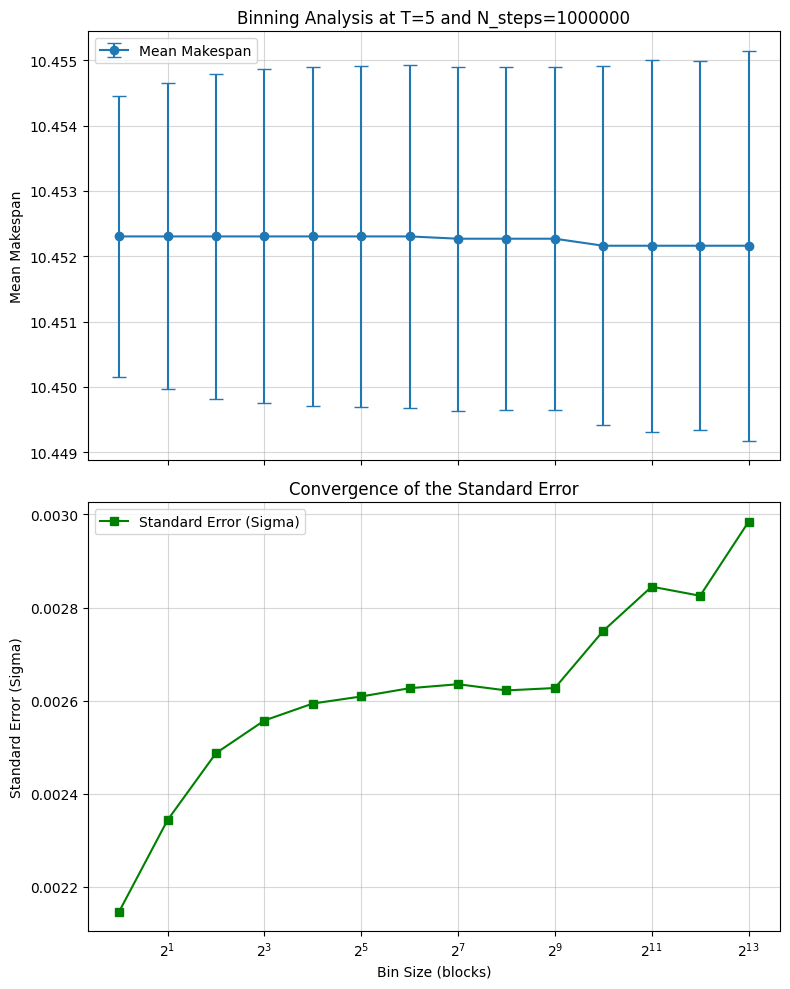

AC time: 0.4660559726143906
Mean makespan during simulation: 10.452255758257625
1        10.452304       2.146943e-03   
2        10.452304       2.343589e-03   
4        10.452304       2.487301e-03   
8        10.452304       2.557474e-03   
16       10.452304       2.593918e-03   
32       10.452304       2.609074e-03   
64       10.452304       2.626862e-03   
128      10.452269       2.635389e-03   
256      10.452269       2.622086e-03   
512      10.452269       2.627265e-03   
1024     10.452161       2.750109e-03   
2048     10.452161       2.844971e-03   
4096     10.452161       2.825416e-03   
8192     10.452161       2.984260e-03   


In [115]:
#---Simulation for T=5 and n_steps=1000000---

#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

#Number of steps
n_steps = 1000000

#Temperature used in Metropolis algorithm
T = 5

#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps=n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")



Final assigment: [0 0 0 1]
Final makespan: 10.0
Acceptance ratio swap: 0.571402
Acceptance ratio migration: 0.168013


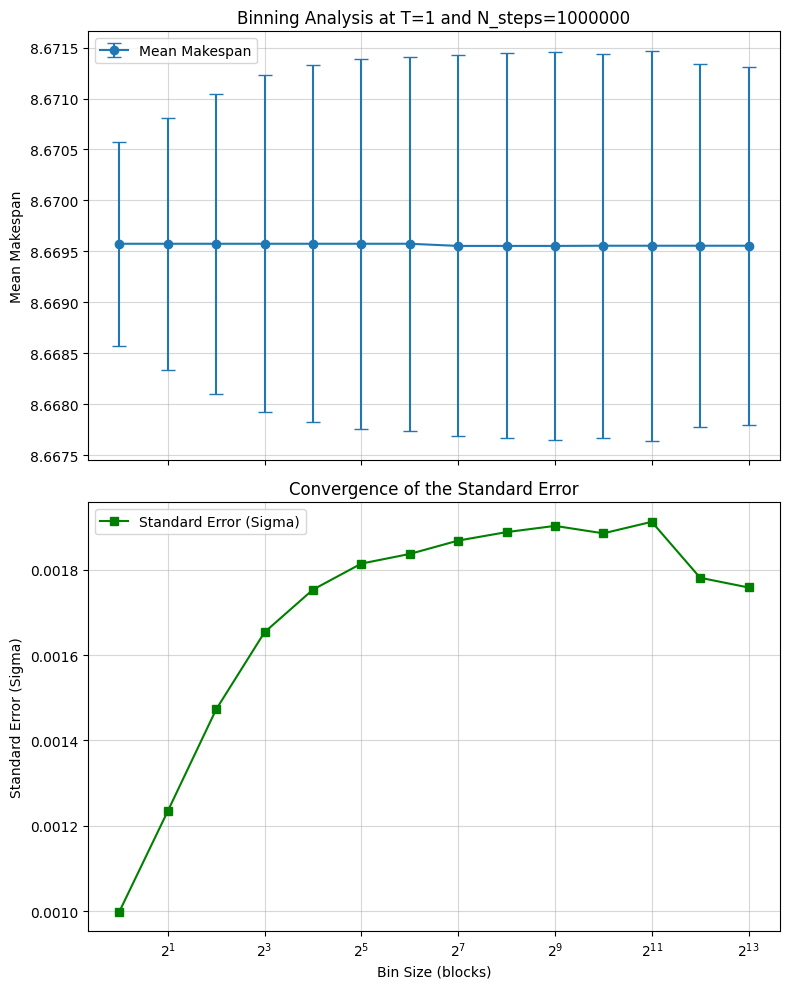

AC time: 1.3325712636226095
Mean makespan during simulation: 8.669564943613535
1        8.669575        9.988270e-04   
2        8.669575        1.234241e-03   
4        8.669575        1.472720e-03   
8        8.669575        1.653505e-03   
16       8.669575        1.753297e-03   
32       8.669575        1.814334e-03   
64       8.669575        1.836921e-03   
128      8.669554        1.868238e-03   
256      8.669554        1.888067e-03   
512      8.669554        1.902668e-03   
1024     8.669556        1.885211e-03   
2048     8.669556        1.912210e-03   
4096     8.669556        1.781098e-03   
8192     8.669556        1.758310e-03   


In [116]:
#---Simulation for T=1 and n_steps=1000000---

#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

#Number of steps
n_steps = 1000000

#Temperature used in Metropolis algorithm
T = 1

#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps=n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")


Final assigment: [1 1 0 0]
Final makespan: 8.0
Acceptance ratio swap: 0.333258
Acceptance ratio migration: 1e-06


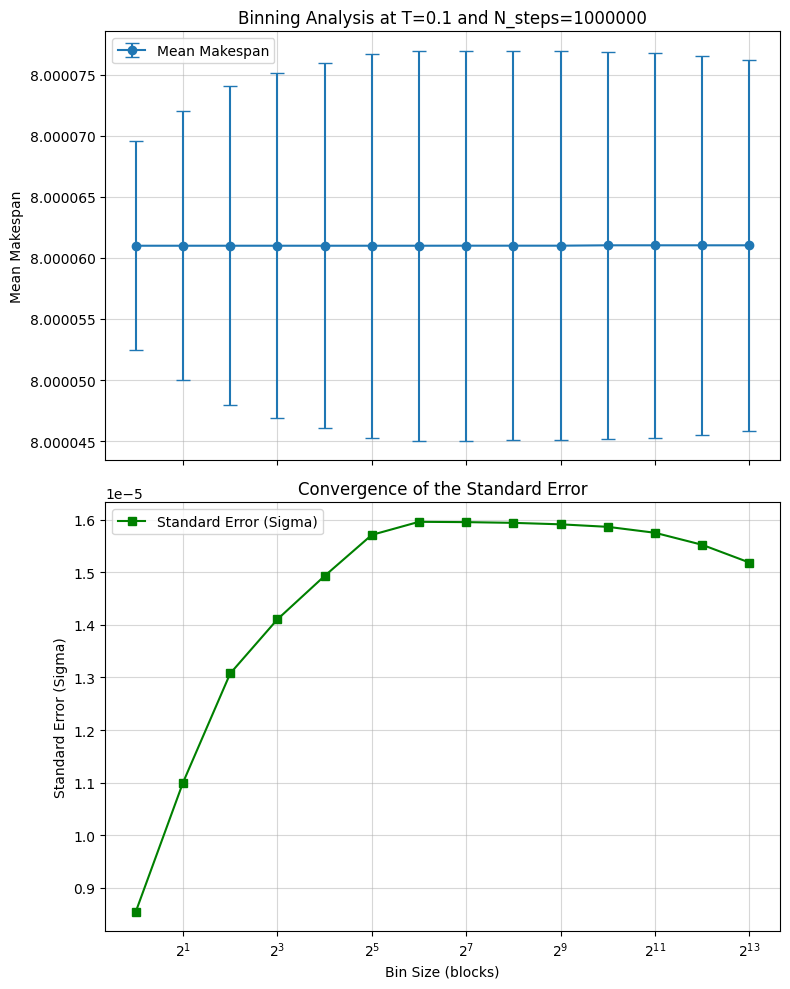

AC time: 1.245143112186539
Mean makespan during simulation: 8.000061010881268
1        8.000061        8.543790e-06   
2        8.000061        1.099967e-05   
4        8.000061        1.307615e-05   
8        8.000061        1.410574e-05   
16       8.000061        1.493131e-05   
32       8.000061        1.571270e-05   
64       8.000061        1.596177e-05   
128      8.000061        1.595584e-05   
256      8.000061        1.594192e-05   
512      8.000061        1.591404e-05   
1024     8.000061        1.586616e-05   
2048     8.000061        1.575337e-05   
4096     8.000061        1.552463e-05   
8192     8.000061        1.518730e-05   


In [117]:
#---Simulation for T=0.1 and n_steps=1000000---

#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

#Number of steps
n_steps = 1000000

#Temperature used in Metropolis algorithm
T = 0.1

#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps=n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")


In [99]:
#Defining one algorithm step with temperature return
def MC_step_term(task_dur, assigment, n_workers, T, dT, acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps, makespan_list):

    #Step 1: Calculate initial makespan
    makespan = calculate_makespan(task_dur, assigment)

    #Step 2: Make the swap
    assigment_swap = task_swap(assigment)

    #Step 3: calculate new makespan
    new_makespan = calculate_makespan(task_dur, assigment_swap)

    #Step 4: Apply Metropolis criteria
    if new_makespan < makespan :
        #Acept new config
        assigment = assigment_swap
        acep_swap_steps = acep_swap_steps + 1
    else:
        probability = np.exp(-(new_makespan-makespan)/T)
        rnd_n = random.random()
        if rnd_n < probability :
            #Acept new config
            assigment = assigment_swap
            acep_swap_steps = acep_swap_steps + 1
        else:
            canc_swap_steps = canc_swap_steps + 1

    #Step 5 : Make the migration
    assigment_migr = task_migration(assigment, n_workers)

    #Step 6: calculate new makespan
    new_makespan = calculate_makespan(task_dur, assigment_migr)

    #Step 7: Apply Metropolis criteria
    if new_makespan < makespan :
        #Acept new config
        assigment = assigment_migr
        acep_migr_steps = acep_migr_steps + 1
        makespan_list.append(new_makespan)
    else:
        probability = np.exp(-(new_makespan-makespan)/T)
        rnd_n = random.random()

        if rnd_n < probability :
            #Acept new config
            assigment = assigment_migr
            acep_migr_steps = acep_migr_steps + 1
            makespan_list.append(new_makespan)
        else:
            canc_migr_steps = canc_migr_steps + 1
            makespan_list.append(makespan)
    
    T = T -(dT/n_steps)
    return assigment, acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps, makespan_list, T


Final assigment: [1 1 0 0]
Final makespan: 8.0
Acceptance ratio swap: 0.728031
Acceptance ratio migration: 0.445274


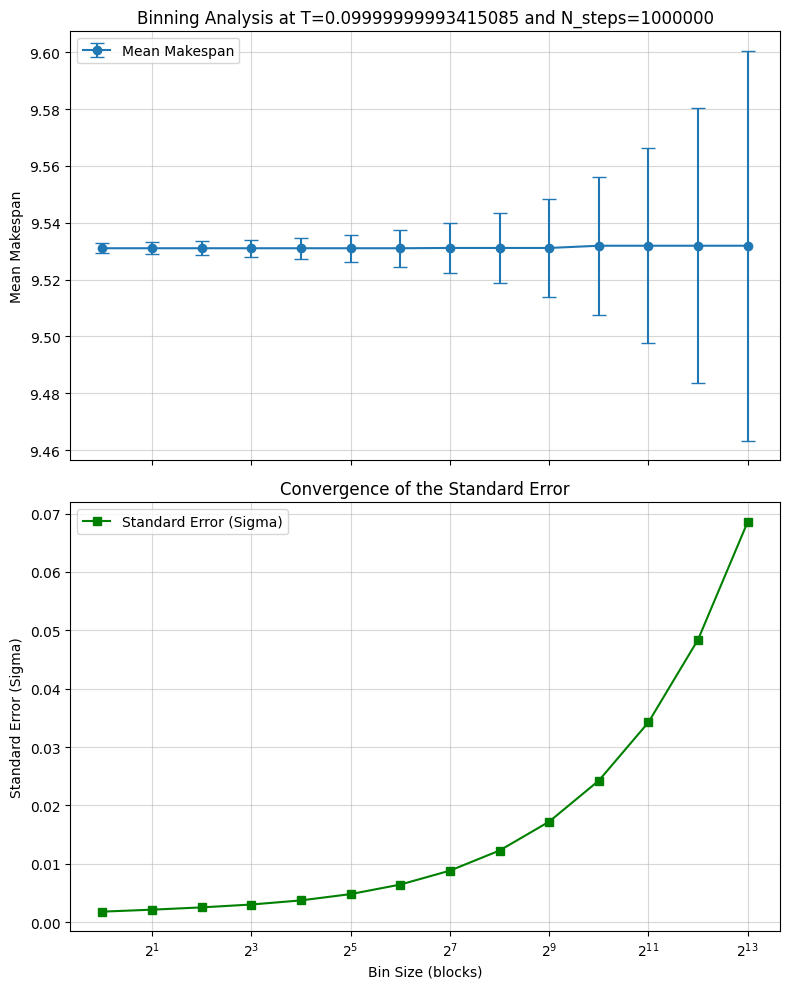

AC time: 709.6565653856795
Mean makespan during simulation: 9.531328111795363
1        9.531055        1.819876e-03   
2        9.531055        2.154624e-03   
4        9.531055        2.547209e-03   
8        9.531055        3.039204e-03   
16       9.531055        3.744216e-03   
32       9.531055        4.823632e-03   
64       9.531055        6.453966e-03   
128      9.531153        8.839411e-03   
256      9.531153        1.228392e-02   
512      9.531153        1.723460e-02   
1024     9.531937        2.426185e-02   
2048     9.531937        3.424668e-02   
4096     9.531937        4.842805e-02   
8192     9.531937        6.858575e-02   


In [118]:
#---Simulation starting with T=5 to T=0.1 and n_steps=1000000---

#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

#Number of steps
n_steps = 1000000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.1)
T = 5
dT = T - 0.1


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps=n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")



Final assigment: [0 0 1 1]
Final makespan: 8.0
Acceptance ratio swap: 0.531191
Acceptance ratio migration: 0.223099


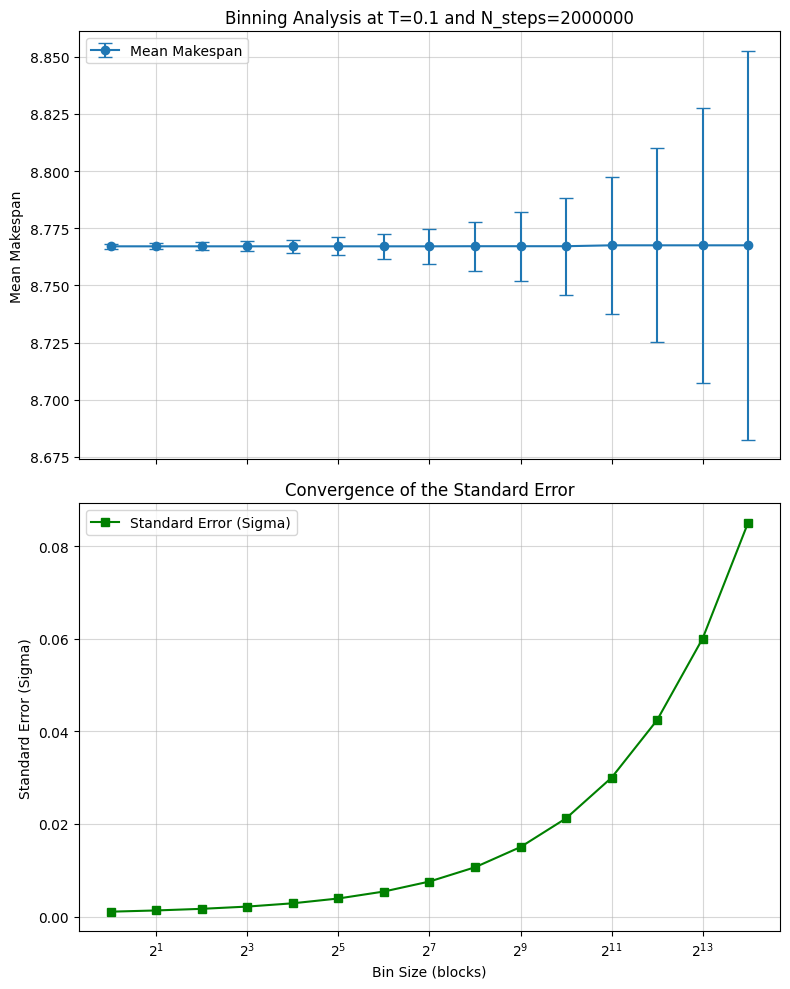

AC time: 3217.6841790979993
Mean makespan during simulation: 8.76721757890059
1        8.767090        1.060429e-03   
2        8.767090        1.324492e-03   
4        8.767090        1.674657e-03   
8        8.767090        2.160242e-03   
16       8.767090        2.870370e-03   
32       8.767090        3.908832e-03   
64       8.767090        5.411207e-03   
128      8.767090        7.568017e-03   
256      8.767139        1.064591e-02   
512      8.767139        1.501622e-02   
1024     8.767139        2.120916e-02   
2048     8.767532        2.999113e-02   
4096     8.767532        4.241954e-02   
8192     8.767532        6.004104e-02   
16384    8.767532        8.507499e-02   


In [ ]:
#---Simulation starting with T=5 to T=0.1 with n_steps=1000000 and then 1000000 steps in equilibrium, recording also equilibration makespan---

#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

#Number of steps
n_steps = 1000000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.1)
T = 5
dT = T - 0.1


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )

#Now we do 1000000 steps more with T=0.1
T = 0.1
for i in range(n_steps):
      (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
      
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps= 2 * n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")



Final assigment: [0 0 1 1]
Final makespan: 8.0
Acceptance ratio swap: 0.333762
Acceptance ratio migration: 0.0


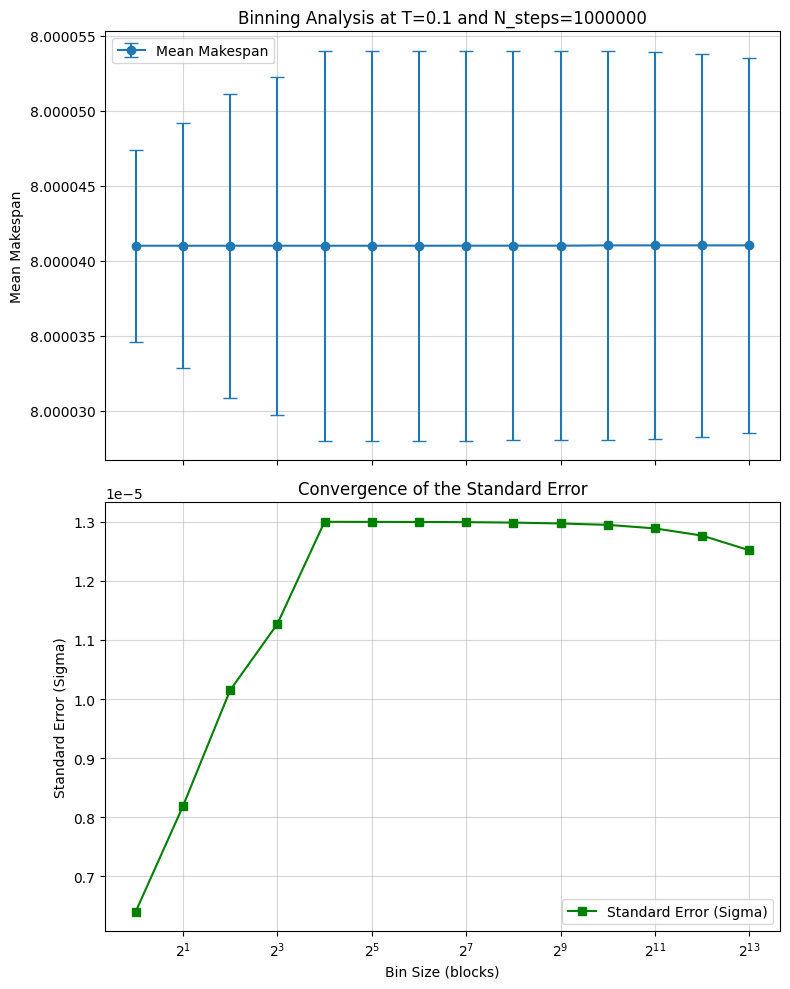

AC time: 1.5607630112482735
Mean makespan during simulation: 8.000041007313639
1        8.000041        6.402996e-06   
2        8.000041        8.185156e-06   
4        8.000041        1.014858e-05   
8        8.000041        1.126888e-05   
16       8.000041        1.299907e-05   
32       8.000041        1.299814e-05   
64       8.000041        1.299628e-05   
128      8.000041        1.299338e-05   
256      8.000041        1.298593e-05   
512      8.000041        1.297100e-05   
1024     8.000041        1.294768e-05   
2048     8.000041        1.288746e-05   
4096     8.000041        1.276579e-05   
8192     8.000041        1.251737e-05   


In [ ]:

#---Simulation starting with T=5 to T=0.1 with n_steps=10000 and then 1000000 steps in equilibrium, only recording equilibrium---

#---`Parameters---`

#List of the durations of every task
task_dur = np.array([3, 5, 2, 6])

#Number of workers
n_workers = 2

#Number of steps for equilibration
n_steps = 10000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.1)
T = 5
dT = T - 0.1


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )

#Now we do 1000000 steps more with T=0.1
T = 0.1
n_steps = 1000000

#We reiniciate parameters for the long equilibrium run
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

makespan_list = []

for i in range(n_steps):
      (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
      
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps= n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")



In [103]:


def generate_tasks(n_task,n_workers, seed=42):
    np.random.seed(seed) #Reproducibility
    
    # Generate times for each task between 10 and 100
    task_list = np.random.randint(low=10, high=100, size=n_task)
    
    
    print(f"Tareas: {n_task} | Trabajadores: {n_workers}")
    print(f"Cota inferior teórica (Suma/Trabajadores): {task_list.sum() / n_workers:.2f}")
    
    return task_list



Tareas: 100 | Trabajadores: 10
Cota inferior teórica (Suma/Trabajadores): 566.80
Final assigment: [3 9 0 4 5 0 8 9 6 5 0 9 9 0 4 7 3 9 5 8 6 5 2 7 1 6 4 4 4 5 2 4 9 2 1 8 7
 8 6 2 7 8 8 5 0 5 5 4 7 2 3 7 7 5 1 9 6 3 2 2 4 6 9 1 0 0 4 5 9 0 6 1 1 9
 9 1 2 3 1 3 8 9 2 7 5 3 2 6 3 4 3 8 3 6 1 0 8 8 8 5]
Final makespan: 567.0
Acceptance ratio swap: 0.109738
Acceptance ratio migration: 3e-06


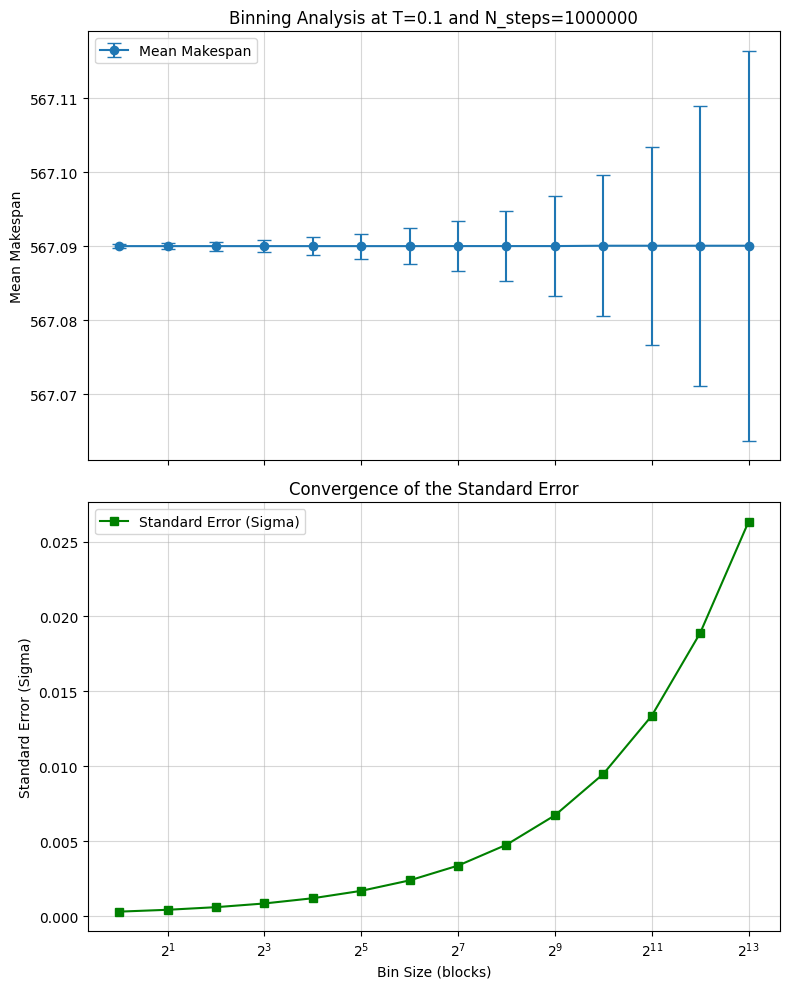

AC time: 3893.6675037711907
Mean makespan during simulation: 567.0900180546862
1        567.090002      2.982209e-04   
2        567.090002      4.217412e-04   
4        567.090002      5.964277e-04   
8        567.090002      8.434458e-04   
16       567.090002      1.192774e-03   
32       567.090002      1.686698e-03   
64       567.090002      2.384945e-03   
128      567.090008      3.371816e-03   
256      567.090008      4.764615e-03   
512      567.090008      6.725676e-03   
1024     567.090054      9.488088e-03   
2048     567.090054      1.336926e-02   
4096     567.090054      1.889199e-02   
8192     567.090054      2.631846e-02   


In [121]:
#---Random task generation example---

#---Simulation starting with T=5 to T=0.1 with n_steps=10000 and then 1000000 steps in equilibrium---

#---`Parameters---`

#Number of tasks
n_task = 100

#Number of workers
n_workers = 10

#List of the durations of every task
task_dur = generate_tasks(n_task, n_workers)

#Number of steps for equilibration
n_steps = 10000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.1)
T = 5
dT = T - 0.1


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )

#Now we do 1000000 steps more with T=0.1
T = 0.1
n_steps = 1000000

#We reiniciate parameters for the long equilibrium run

acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

makespan_list = []

for i in range(n_steps):
      (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
      
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=100)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps= n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)


for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")



Tareas: 100 | Trabajadores: 10
Cota inferior teórica (Suma/Trabajadores): 566.80
Final assigment: [0 1 7 9 5 0 4 7 0 6 4 8 5 0 0 7 6 0 1 3 1 1 3 5 6 5 4 1 9 4 7 7 3 6 9 7 3
 0 8 7 6 4 2 1 5 1 9 9 3 2 7 9 8 8 9 2 3 9 2 4 1 8 2 4 9 3 4 9 2 5 8 6 6 2
 0 6 9 2 8 4 0 2 4 8 6 1 2 5 5 1 1 9 3 3 5 9 8 1 2 8]
Final makespan: 574.0
Acceptance ratio swap: 0.264813
Acceptance ratio migration: 0.047441


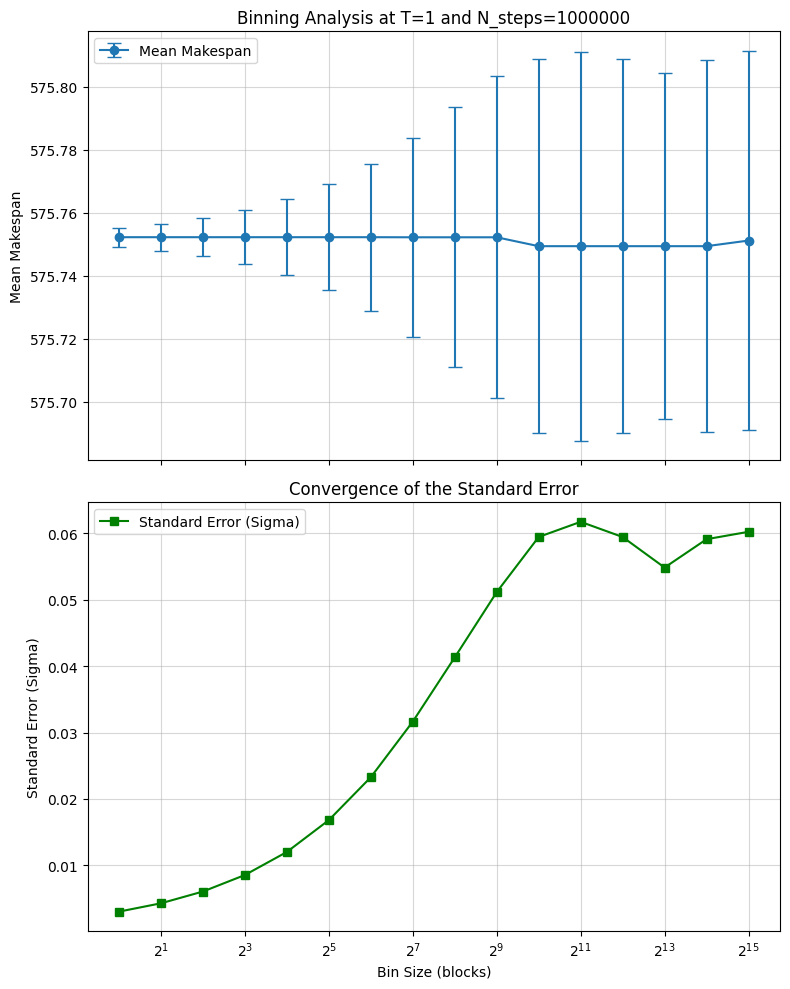

AC time: 204.99832058707682
Mean makespan during simulation: 575.7512239074301
1        575.752186      3.044493e-03   
2        575.752186      4.300432e-03   
4        575.752186      6.070905e-03   
8        575.752186      8.558394e-03   
16       575.752186      1.202937e-02   
32       575.752186      1.681993e-02   
64       575.752186      2.327816e-02   
128      575.752157      3.164768e-02   
256      575.752157      4.131379e-02   
512      575.752157      5.113848e-02   
1024     575.749338      5.943988e-02   
2048     575.749338      6.172117e-02   
4096     575.749338      5.943622e-02   
8192     575.749338      5.483527e-02   
16384    575.749338      5.910367e-02   
32768    575.751121      6.021789e-02   


In [ ]:
#---Random task generation example---

#---Simulation starting with T=5 to T=1 with n_steps=10000 and then 1000000 steps in equilibrium---

#---`Parameters---`

#Number of tasks
n_task = 100

#Number of workers
n_workers = 10

#List of the durations of every task
task_dur = generate_tasks(n_task, n_workers)

#Number of steps for equilibration
n_steps = 10000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.1)
T = 5
dT = T - 1


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )

#Now we do 1000000 steps more with T=1
T = 1
n_steps = 1000000

#We reiniciate parameters for the long equilibrium run

acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

makespan_list = []

for i in range(n_steps):
      (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
      
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=30)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps= n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)

for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")



Tareas: 100 | Trabajadores: 10
Cota inferior teórica (Suma/Trabajadores): 566.80
Final assigment: [6 3 3 5 2 4 5 3 0 9 9 2 4 1 1 6 1 8 6 3 7 9 6 2 3 8 8 1 1 6 0 9 1 2 9 8 5
 2 5 4 7 3 3 9 7 3 8 6 4 8 8 3 8 7 4 0 8 6 5 8 5 9 4 2 1 0 6 5 9 4 7 2 5 5
 3 7 4 7 7 1 1 6 6 0 9 7 0 1 1 2 9 7 8 6 4 5 2 2 0 0]
Final makespan: 571.0
Acceptance ratio swap: 0.151118
Acceptance ratio migration: 0.001832


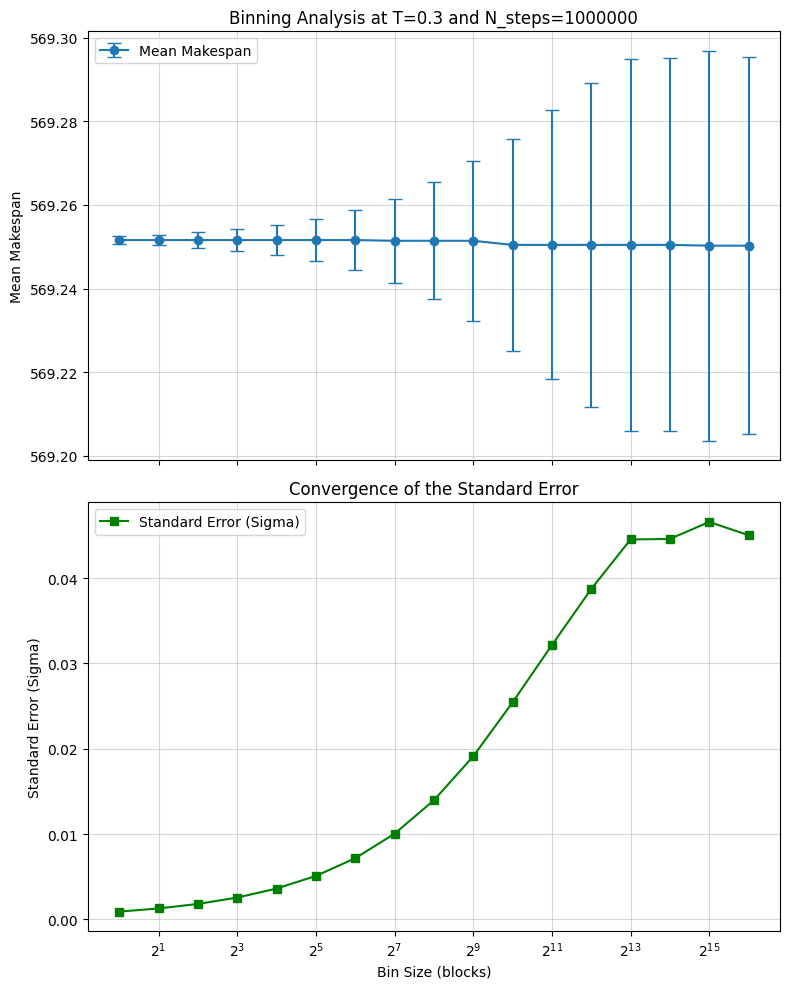

AC time: 1325.9120114427835
Mean makespan during simulation: 569.2510828666965
1        569.251611      9.047053e-04   
2        569.251611      1.279140e-03   
4        569.251611      1.808336e-03   
8        569.251611      2.555633e-03   
16       569.251611      3.609494e-03   
32       569.251611      5.091941e-03   
64       569.251611      7.167505e-03   
128      569.251437      1.004384e-02   
256      569.251437      1.395863e-02   
512      569.251437      1.911194e-02   
1024     569.250456      2.543972e-02   
2048     569.250456      3.215912e-02   
4096     569.250456      3.873143e-02   
8192     569.250456      4.454190e-02   
16384    569.250456      4.460303e-02   
32768    569.250270      4.659737e-02   
65536    569.250270      4.504255e-02   


In [ ]:
#---Random task generation example---

#---Simulation starting with T=5 to T=0.3 with n_steps=10000 and then 1000000 steps in equilibrium---

#---`Parameters---`

#Number of tasks
n_task = 100

#Number of workers
n_workers = 10

#List of the durations of every task
task_dur = generate_tasks(n_task, n_workers)

#Number of steps for equilibration
n_steps = 10000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.1)
T = 5
dT = T - 0.3


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )

#Now we do 1000000 steps more with T=0.3
T = 0.3
n_steps = 1000000

#We reiniciate parameters for the long equilibrium run

acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

makespan_list = []

for i in range(n_steps):
      (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
      
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=10)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps= n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)


for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")


Tareas: 100 | Trabajadores: 10
Cota inferior teórica (Suma/Trabajadores): 566.80
Final assigment: [0 1 1 8 3 2 4 2 3 6 7 9 7 7 8 7 5 0 2 9 4 1 7 9 7 7 5 1 9 6 7 0 8 4 1 6 3
 0 5 0 2 8 8 3 6 7 3 5 8 4 5 5 0 9 5 8 6 2 4 4 8 0 2 6 3 1 2 7 5 5 9 7 8 3
 9 3 3 3 9 4 2 0 2 9 4 5 2 1 1 6 1 6 0 5 8 3 0 3 5 4]
Final makespan: 570.0
Acceptance ratio swap: 0.1516193
Acceptance ratio migration: 0.0019351


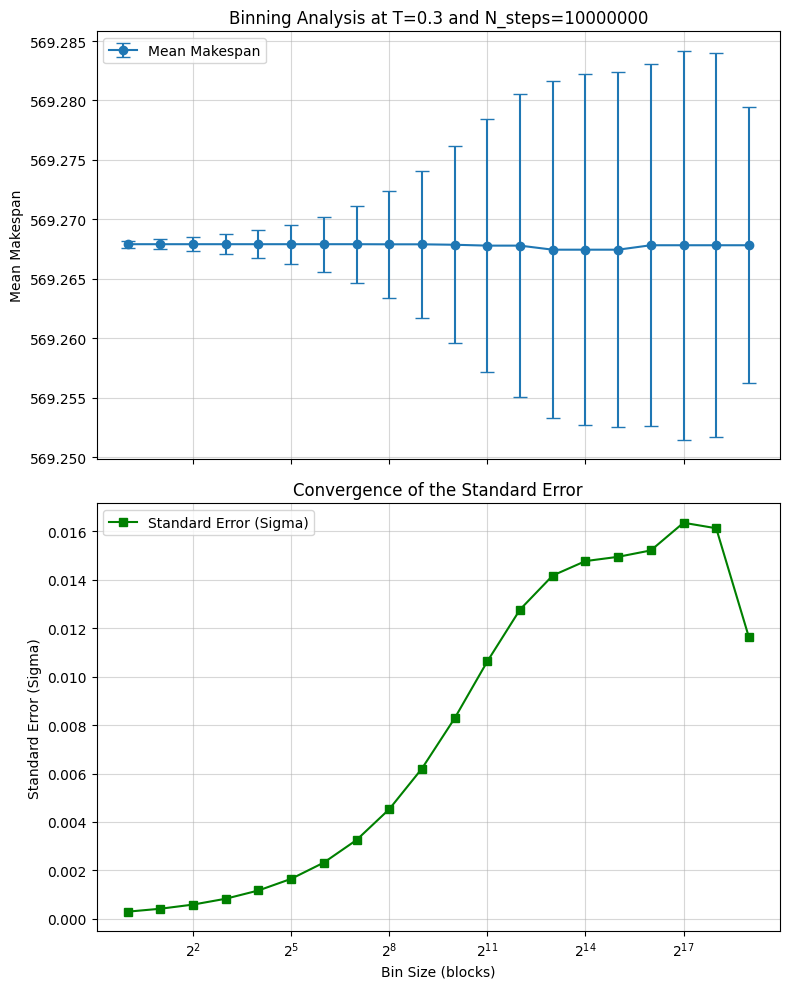

AC time: 1560.7680408376118
Mean makespan during simulation: 569.2678067456534
1        569.267909      2.927315e-04   
2        569.267909      4.138873e-04   
4        569.267909      5.851175e-04   
8        569.267909      8.269328e-04   
16       569.267909      1.168021e-03   
32       569.267909      1.647902e-03   
64       569.267909      2.319592e-03   
128      569.267909      3.252038e-03   
256      569.267899      4.524322e-03   
512      569.267899      6.203629e-03   
1024     569.267862      8.278397e-03   
2048     569.267789      1.063011e-02   
4096     569.267789      1.277286e-02   
8192     569.267447      1.417815e-02   
16384    569.267447      1.477422e-02   
32768    569.267447      1.495055e-02   
65536    569.267821      1.521487e-02   
131072   569.267821      1.635774e-02   
262144   569.267821      1.612986e-02   
524288   569.267821      1.162407e-02   


In [ ]:
#---Random task generation example---

#---Simulation starting with T=5 to T=0.3 with n_steps=10000 and then 10000000 steps in equilibrium---

#---`Parameters---`

#Number of tasks
n_task = 100

#Number of workers
n_workers = 10

#List of the durations of every task
task_dur = generate_tasks(n_task, n_workers)

#Number of steps for equilibration
n_steps = 10000

#Temperature used in Metropolis algorithm (we will start with T=5 and decrease it to T=0.3)
T = 5
dT = T - 0.3


#We create initial random assigment
assigment = create_initial_assigment(task_dur, n_workers)

#We iniciate the acepted and canceled steps
acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

#We iniciate the makespan list
makespan_list = []


#Main algorithm
for i in range(n_steps):
    (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list,
        T
    ) = MC_step_term(
        task_dur, 
        assigment, 
        n_workers, 
        T,
        dT,
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )

#Now we do 10000000 steps more with T=0.3
T = 0.3
n_steps = 10000000

#We reiniciate parameters for the long equilibrium run

acep_swap_steps = 0
canc_swap_steps = 0

acep_migr_steps = 0
canc_migr_steps = 0

makespan_list = []

for i in range(n_steps):
      (
        assigment, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    ) = MC_step(
        task_dur, 
        assigment, 
        n_workers, 
        T, 
        acep_swap_steps, 
        canc_swap_steps, 
        acep_migr_steps, 
        canc_migr_steps,
        makespan_list
    )
      
print("Final assigment:", assigment)
print("Final makespan:", makespan_list[-1])

#Aceptance analysis
acept_ratio_swap, acept_ratio_migr = acept_analysis(acep_swap_steps, canc_swap_steps, acep_migr_steps, canc_migr_steps)
print("Acceptance ratio swap:", acept_ratio_swap)
print("Acceptance ratio migration:", acept_ratio_migr)

#Binning analysis
bin_sizes, makespan_errors, makespan_means, AC_time, mean_makespan = binning_analysis(makespan_list, min_bins=10)
plotting_bins(bin_sizes, makespan_means, makespan_errors, T, n_steps= n_steps)

print('AC time:', AC_time)
print('Mean makespan during simulation:', mean_makespan)


for m, em, err in zip(bin_sizes, makespan_means, makespan_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")
